# HW4

Parts 1-4 are in class/suggestions/guides

---
Helpful imports, plotting defaults, and data directories


In [1]:
# import block
import numpy as np
from astropy.nddata import CCDData
from astropy.io import fits
%matplotlib inline
from matplotlib import pyplot as plt
from astropy.visualization import hist
import ccdproc as ccdp
from matplotlib import rc
import os

# for fitting models
from astropy.modeling import fitting
from astropy.modeling.models import Polynomial1D,Chebyshev1D,Legendre1D,Hermite1D

In [2]:
# plotting defaults
# Use custom style for larger fonts and figures
phot_tutorial_dir = '/home/kyle/Homework/Astro8060/ccd-reduction-and-photometry-guide/notebooks'
plt.style.use(phot_tutorial_dir+'/guide.mplstyle')

# Set some default parameters for the plots below
rc('font', size=12)
rc('axes', grid=True)

In [3]:
# define directories
data_dir = '/home/kyle/Homework/Astro8060/NoBackupImages/raw/'
reduced_dir = '/home/kyle/Homework/Astro8060/NoBackupImages/reduced/'

---

## Part 3

Assess the RMS and mean levels of an image. Use Python to practice plotting lines and columns of data from one of the bias images. Use Python to compute the mean and RMS of a region near the center of the chip

---

The RMS of a093.fits: 9.53, the mean is: 665.83


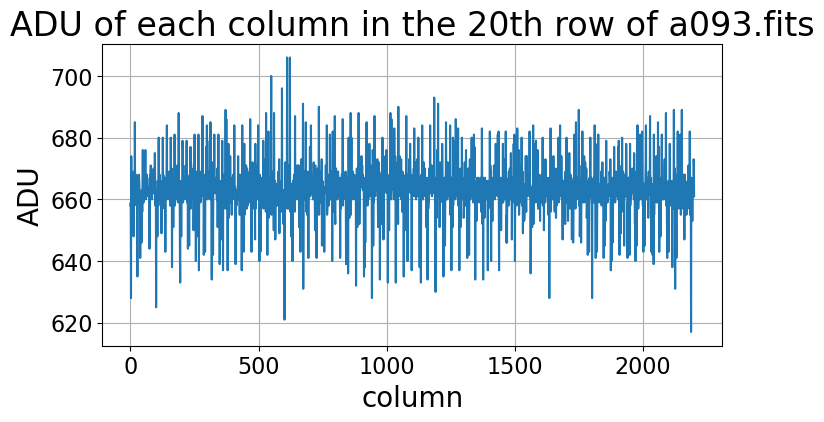

In [4]:
biasImg = fits.open(reduced_dir+'a093.fits')

#Print the RMS and Mean of the overall image
print('The RMS of a093.fits: {0:4.2f}, the mean is: {1:4.2f}'.format(np.std(biasImg[0].data), np.mean(biasImg[0].data)))

#Plot a line in the image
plt.figure(figsize=(8,4))
plt.title('ADU of each column in the 20th row of a093.fits')
plt.xlabel('column')
plt.ylabel('ADU')
plt.plot(biasImg[0].data[20])
plt.show()

In [5]:
#Mean and RMS around the center of the image (innermost 100x100 pixels)
midY = int(0+2048/2)
midX = int(54+2048/2)
midBias = biasImg[0].data[midY-50:midY+50, midX-50:midX+50]
print('Mean in middle of a093.fits: {0:4.2f} ADU'.format(np.mean(midBias)))
print('RMS in middle of a093.fits: {0:4.2f} ADU'.format(np.std(midBias)))

del biasImg

Mean in middle of a093.fits: 671.39 ADU
RMS in middle of a093.fits: 8.84 ADU


---

### Part 5

Examine the all bias exposures (or overscan regions throughout the night) and quantify
how much the bias level changes throughout the night. Compare the mean level of the
biases to the mean levels of the overscan regions from other files throughout the night.
How much variation do you find? Make an argument for whether it would be a good or
bad idea to combine all of the biases to make a master bias and subtract that from all the
images versus using the overscan region of each image as an estimate of the bias level.

---

In [6]:
#Get bias files
#Bias files are from a093 to a111
fileNums = np.arange(93,112) #Will exclude last number

#Get file names
bias_files = [reduced_dir+'a'+str(i).zfill(3)+'.fits' for i in fileNums]

#Open each file and extract each HDU, header, and data
HDUs = [fits.open(file) for file in bias_files]
HDRs = [hdu[0].header for hdu in HDUs]
BIAS_DATA = [hdu[0].data for hdu in HDUs]

del HDUs
del HDRs

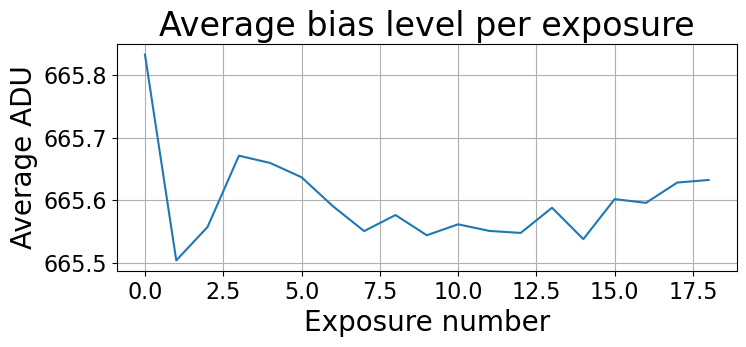

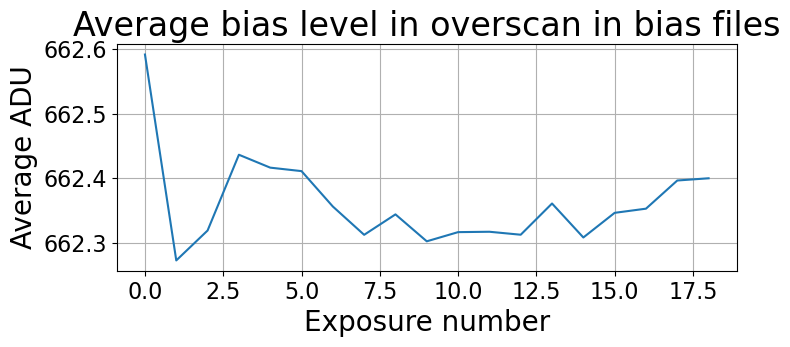

In [7]:
#Plot FULL FRAME average bias level for each bias frame
averageBiases = [np.average(bias) for bias in BIAS_DATA]
plt.figure(figsize=(8,3))
plt.plot(np.arange(19),averageBiases)
plt.title('Average bias level per exposure')
plt.xlabel('Exposure number')
plt.ylabel('Average ADU')
plt.show()

#Plot OVERSCAN average bias level for each frame
#first pair is y axis range, second pair is x axis range
overY = [1,2048]
overX = [2102+20,2200] #Plus 20 is to get away from all data
averageBiasOverscan = []
for bias in BIAS_DATA:
    data = np.array(bias)
    overscan = bias[ overY[0]:overY[1] , overX[0]:overX[1] ]
    averageBiasOverscan.append(np.average(overscan))

plt.figure(figsize=(8,3))
plt.plot(np.arange(19),averageBiasOverscan)
plt.title('Average bias level in overscan in bias files')
plt.xlabel('Exposure number')
plt.ylabel('Average ADU')
plt.show()

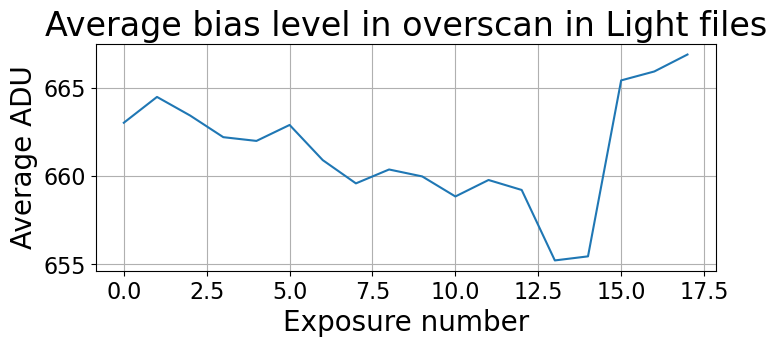

In [8]:
#Look at the overscan region of the light frames throughout the night

#Get light frames
#Light files for this test are from a112 to a129
fileNums = np.arange(112,130) #Will exclude last number

#Get file names
light_files = [reduced_dir+'a'+str(i).zfill(3)+'.fits' for i in fileNums]

#Open each file and extract each HDU, header, and data
light_HDUs = [fits.open(file) for file in light_files]
light_HDRs = [hdu[0].header for hdu in light_HDUs]
LIGHT_DATA = [hdu[0].data for hdu in light_HDUs]

del light_HDUs
del light_HDRs

averageLightOverscan = []
for light in LIGHT_DATA:
    data = np.array(light)
    overscan = light[ overY[0]:overY[1] , overX[0]:overX[1] ]
    averageLightOverscan.append(np.average(overscan))

plt.figure(figsize=(8,3))
plt.plot(np.arange(130-112),averageLightOverscan)
plt.title('Average bias level in overscan in Light files')
plt.xlabel('Exposure number')
plt.ylabel('Average ADU')
plt.show()


del BIAS_DATA
del LIGHT_DATA

### Discussion

Based on these plots, bias frames seem to vary accross the whole image. So if the bias level of the overscan region increases, the bias level of the whole image will increase too. Additionally, the variations between biases are very small, with the largest variation being 0.3. These suggest that combining biases should therefor be a good idea as you want to characterize the total variation across the sensor. and getting an average accross multiple images should smooth out the variations in readings due to uncertanties. 

<b>However</b>, as shown in the light files, the overscan in the lights have much greater variations. This is likely due to the time of night and/or the temperature of the sensor as these can play factors in the bias. When attempting to remove the bias, you should instead scale the combined bias frame with the overscan before subtracting. This should give you a much better result

---

### Part 6

Using CCDPROC.SUBTRACT_OVERSCAN and CCDPROC.TRIM_IMAGE, fit and subtract the overscan region of each image and trim the image to remove the overscan region. In the
overscan fitting, try out ’chebyshev’, ’legendre’, and ’hermite’, and ’polynomial’ of various orders for the fitting function. Qualitatively try to summarize the differences between
the functions (you can also look up and summarize the properties of these types of polynomials, but this is not required). Also try orders 1 through about 8, and make an argument
for how large an order is necessary to fit the overscan region.

---


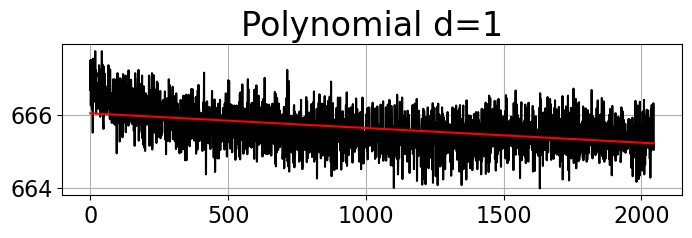

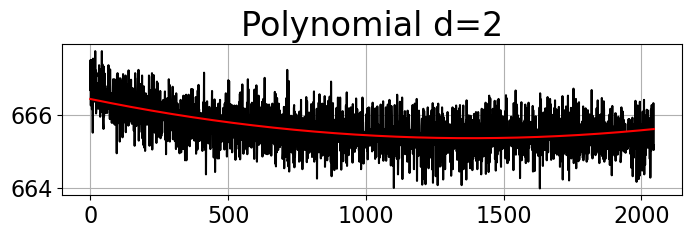

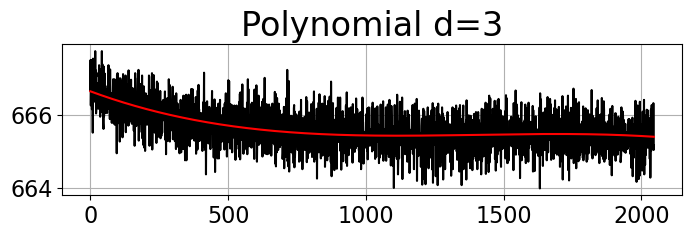

 [astropy.modeling.fitting]


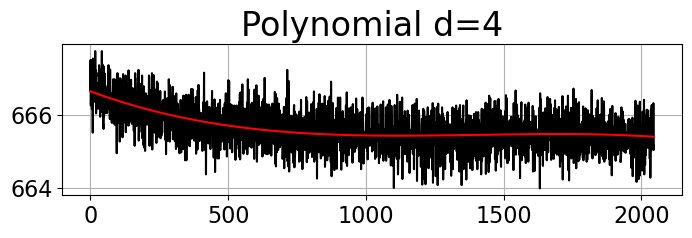

 [astropy.modeling.fitting]


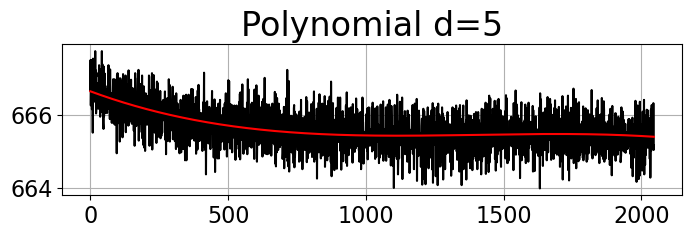

 [astropy.modeling.fitting]


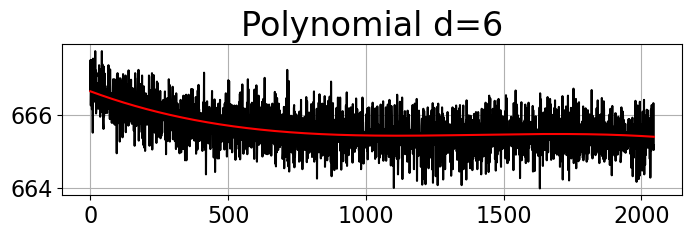

 [astropy.modeling.fitting]


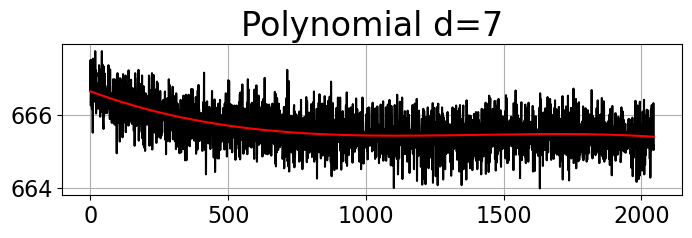

 [astropy.modeling.fitting]


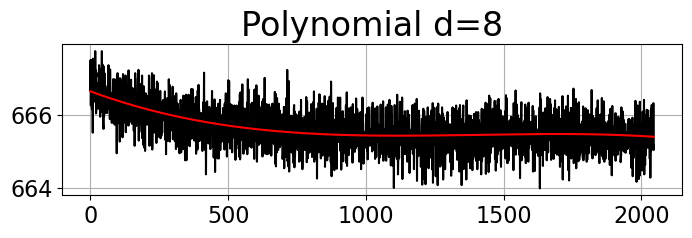

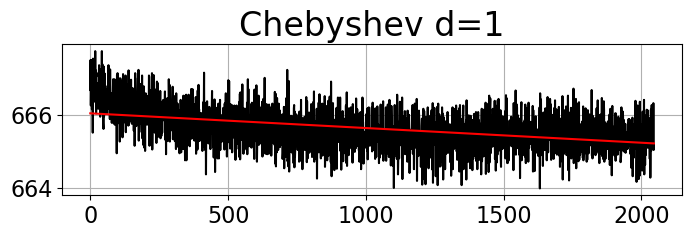

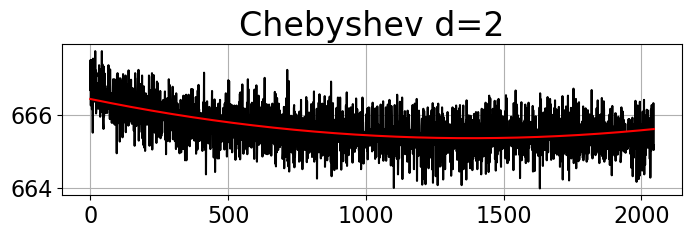

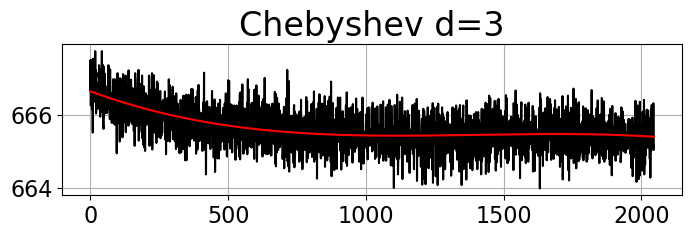

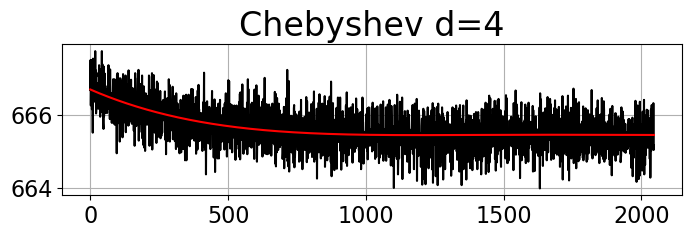

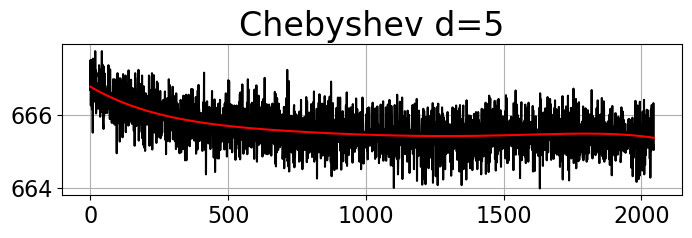

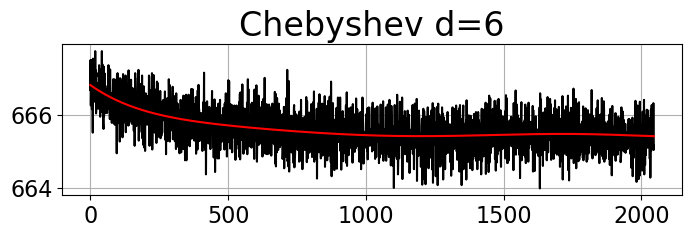

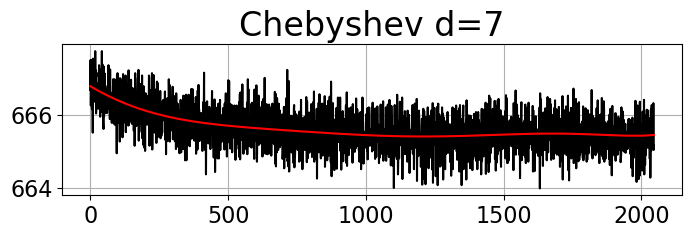

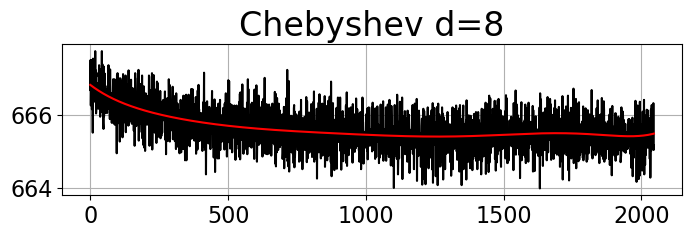

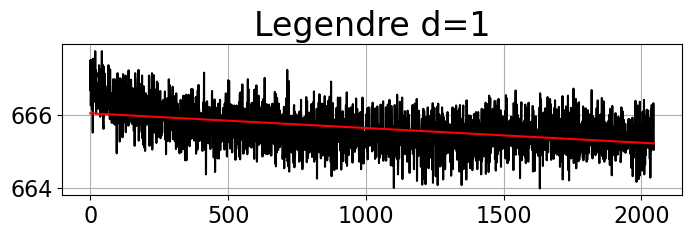

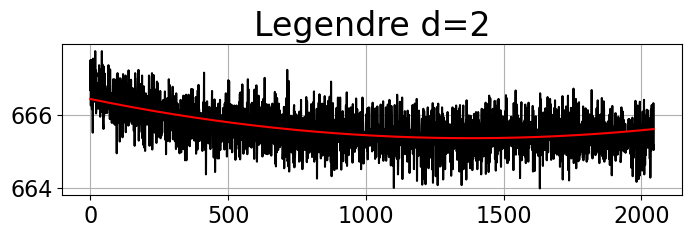

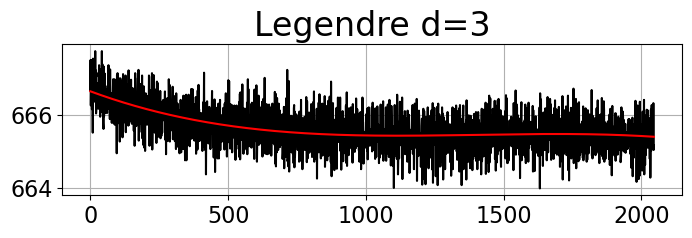

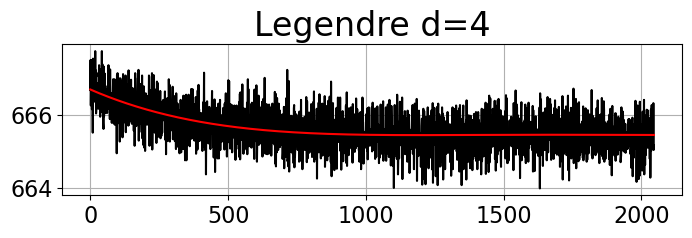

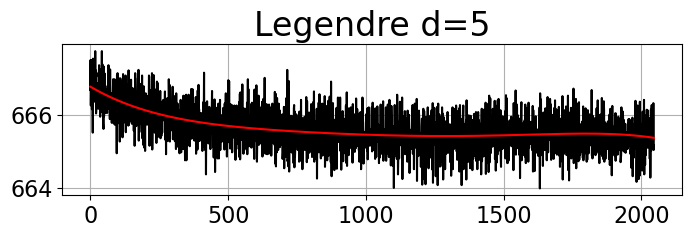

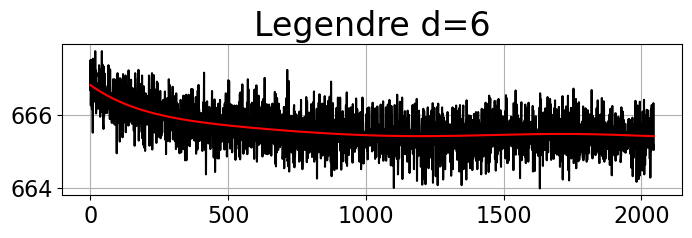

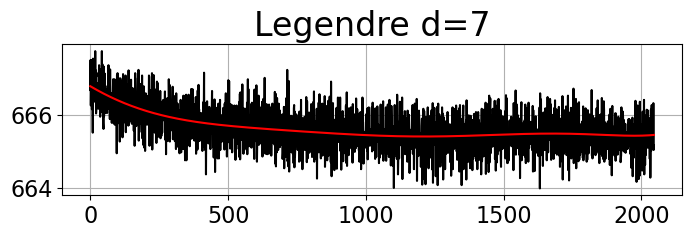

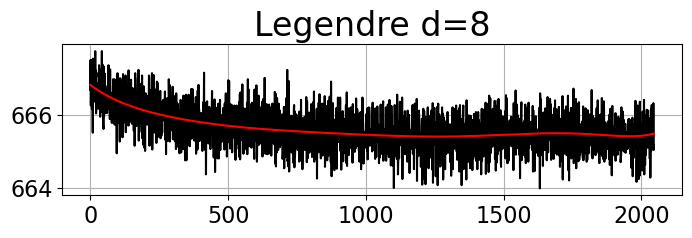

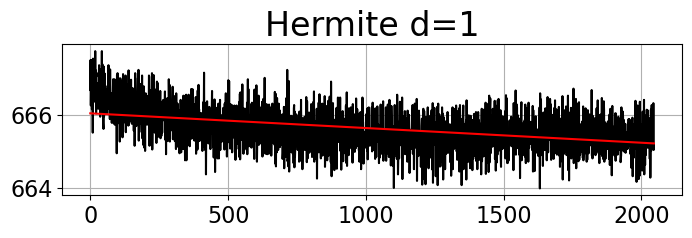

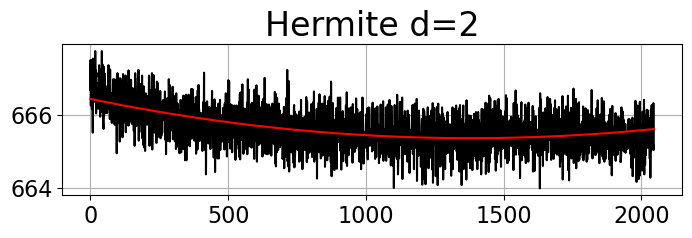

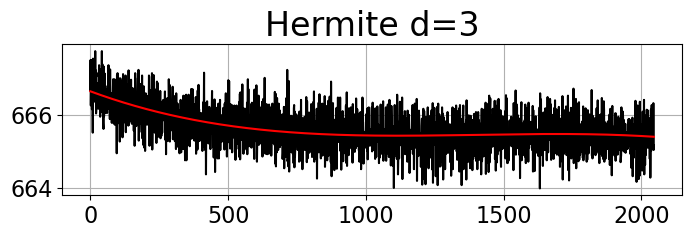

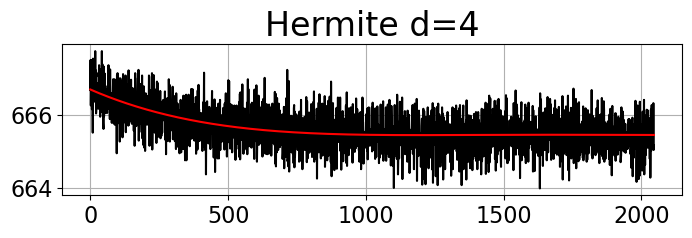

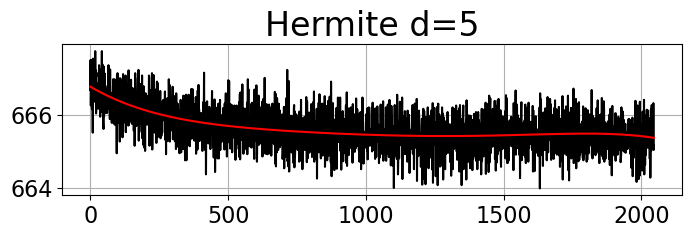

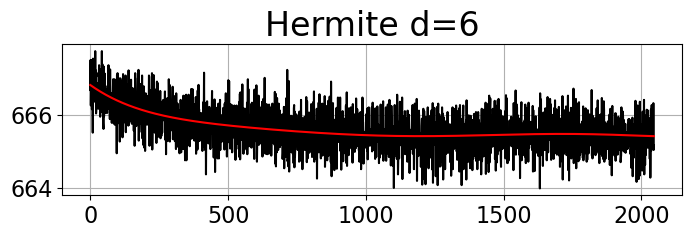

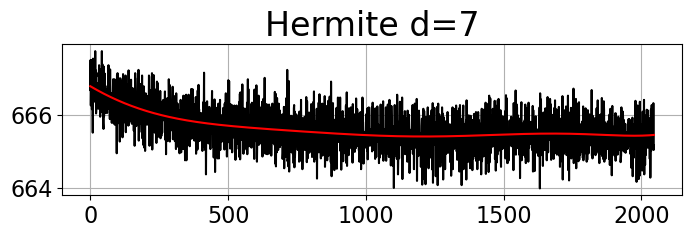

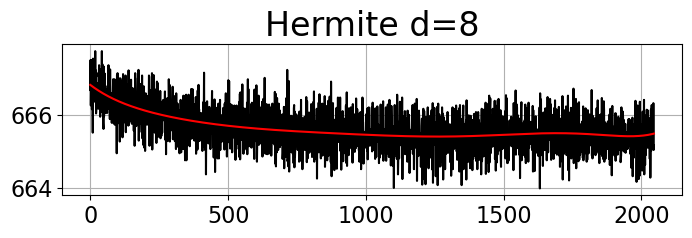

In [9]:
#Select an image to model bias
image = fits.open(reduced_dir+'a212.fits')[0].data
oScan = image[overY[0]:overY[1] , overX[0]:overX[1]]
oScan = np.average(oScan,axis=1)

fitter = fitting.LinearLSQFitter()

#Plot each function type
for i in range(4):
    
    #Plot each degree
    for j in range(1,9):
        if i==0:
            name = "Polynomial d={}".format(j)
            model = Polynomial1D(j)
        elif i==1:
            name = "Chebyshev d={}".format(j)
            model = Chebyshev1D(j)
        elif i==2:
            name = "Legendre d={}".format(j)
            model = Legendre1D(j)
        else:
            name = "Hermite d={}".format(j)
            model = Hermite1D(j)
        
        xVals = np.arange(oScan.shape[0])
        yVals = oScan
        weights = np.ones(shape=oScan.shape[0])
        
        best_fit = fitter(model, xVals, yVals, weights=weights)
        
        plt.figure(figsize=(8,2))
        plt.title(name)
        plt.plot(xVals,yVals,'k-')
        plt.plot(xVals,best_fit(xVals),'r-')
        plt.show()
        

In [10]:
#LOTS of warnings in this section, remove them.
import warnings
warnings.filterwarnings('ignore')

#Get all images in ccdp format
imgs = ccdp.ImageFileCollection(reduced_dir,glob_include='*.fits',glob_exclude='master*')

#Model used to subtract overscan
mod = Polynomial1D(3)

#Put them in a new folder
if not os.path.exists(reduced_dir+'/bias&trim/'):
    os.makedirs(reduced_dir+'/bias&trim/')


for ccd, file_name in imgs.ccds(ccd_kwargs={'unit': 'adu'},return_fname=True):
    
    try:
        ccd = ccdp.subtract_overscan(ccd, overscan=ccd[0:2048,2103:2200], median=False, model=mod) 
        ccd = ccdp.trim_image(ccd,fits_section="[1:2048, 54:2102]") # trim images
        outfile = file_name.strip('.fits')+'ot.fits'
        ccd.write(reduced_dir+'/bias&trim/'+outfile, overwrite=True) # save the result
        
    except:
        print("Had trouble with file \"{}\". Skipping...".format(file_name))
        
del imgs


Had trouble with file "a063.fits". Skipping...
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


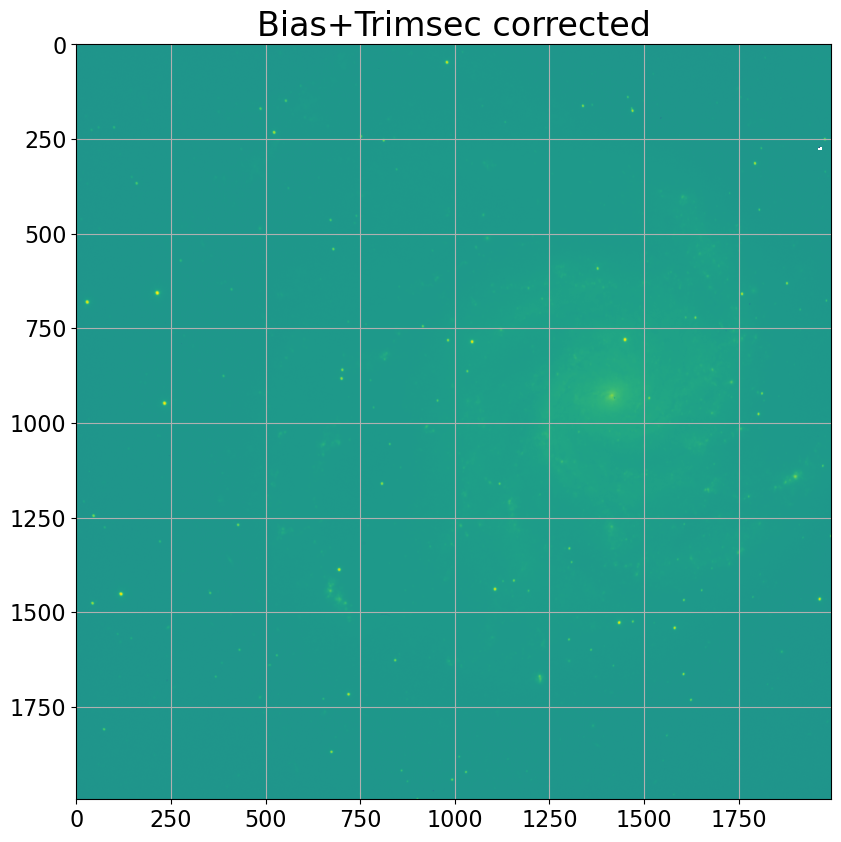

(1995, 1995)


In [11]:
#Show an image to ensure that it worked
img = fits.open(reduced_dir+'bias&trim/a212ot.fits')[0].data[:,53:]
plt.title('Bias+Trimsec corrected')
plt.imshow(np.log(img))
plt.show()
print(img.shape)

### Discussion

Based on the plots generated for each type of fitting function and each degree, there are several qualitative judgements you can make. Firstly, the degree of the approximation doesn't need to be very large. The difference between approximations using degree 7 and 8 are almost non-existant, where as the difference between 1 and 2 is substantial. Since using higher order functions can lead to overfitting, you want to use the simplest model which encapsulates the data. By visual inspection, it appears that order 3 is likely as far as you need to go to get most of the variation in the overscan.

The differences between each type of function seem slight to none in these cases. Likely, using different types of functions will result in different properties that can be used for other purposes (such as differentiation or integration).

### I had to restart here to get the rest to run

---

## Part 7

Combine the bias frames into a master bias frame using CCDPROC.COMBINE. By visual inspection or using image statistics, decide whether it is appropriate to combine all your bias exposures to make 1 master bias, or whether you need to restrict the input frames because of variations among your bias frames. Are there trends in your sequence of bias frames? Does either the level, or the pattern of the bias change throughout the night? If so, by how much? How much noise would you be adding to your data if you decide to do a bias subtraction in addition to your overscan subtraction. Do the subtraction of your master bias from all other science frames if you can justify that it is warranted.

---

In [4]:
import warnings
warnings.filterwarnings('ignore')

#Bias frames
biases = ccdp.ImageFileCollection(reduced_dir,glob_include='*.fits').files_filtered(imagetyp='bias',include_path=True)
bias_data = [CCDData.read(f,unit='adu').data for f in biases]

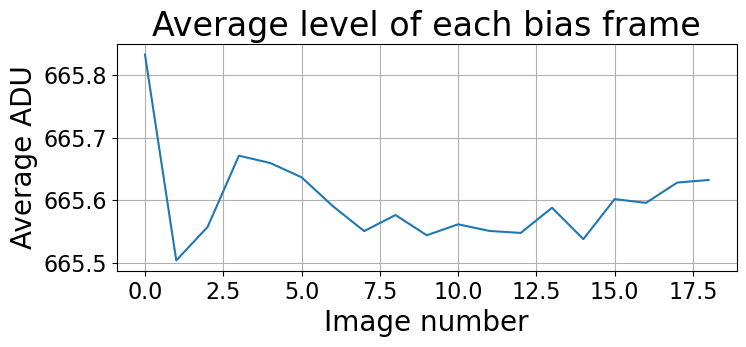

In [5]:
#Find average level in biases
avgBias = [np.average(b) for b in bias_data]
plt.figure(figsize=(8,3))
plt.title('Average level of each bias frame')
plt.ylabel('Average ADU')
plt.xlabel('Image number')
plt.plot(avgBias)
plt.show()

#First bias frame looks much further off than the others. Remove it from the combined image
biases = biases[1:]

INFO:astropy:splitting each image into 11 chunks to limit memory usage to 350000000.0 bytes.


INFO: splitting each image into 11 chunks to limit memory usage to 350000000.0 bytes. [ccdproc.combiner]


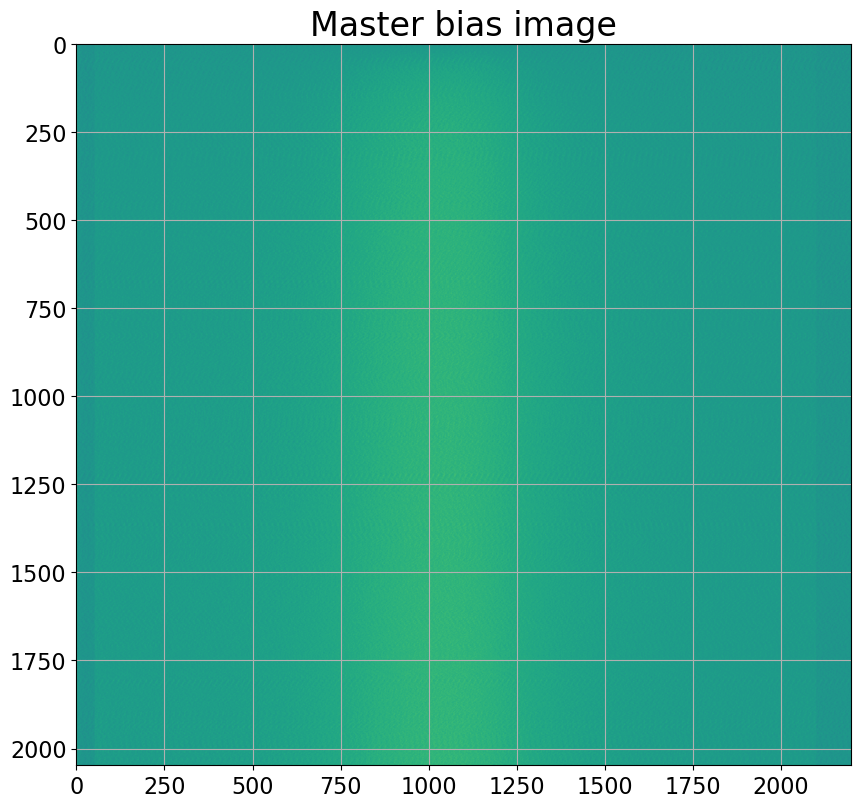

In [6]:
#masterBias = np.average(bias_data,axis=0)
masterBias = ccdp.combine(biases,unit='adu',method='average',sigma_clip=True,mem_limit=350e6)

#Show the image
plt.imshow(np.log(masterBias))
plt.title('Master bias image')
plt.show()

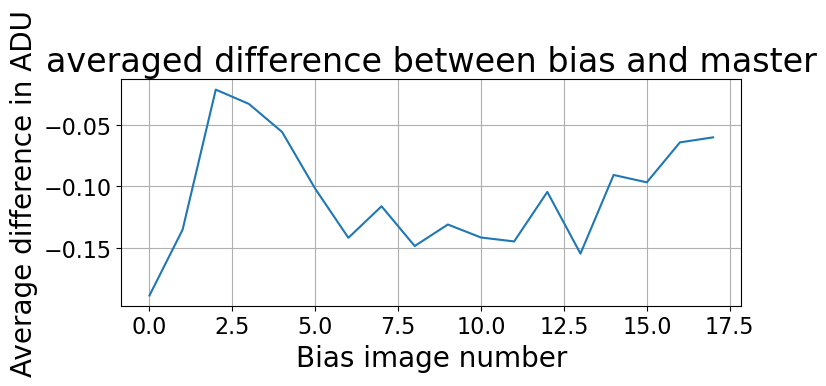

In [7]:
#Take the difference between the master bias and each frame, then take the average difference per frame
difFrames = [bias_data[i] - masterBias.data for i in range(1,len(bias_data))]
avgDif = [np.average(f) for f in difFrames]
plt.figure(figsize=(8,3))
plt.plot(avgDif)
plt.title('averaged difference between bias and master')
plt.ylabel('Average difference in ADU')
plt.xlabel('Bias image number')
plt.show()

del bias_data
del biases
del difFrames
#The plot shows negatives because the master bias removed outliers

### Discussion

By combining the bias frames together, you should cut down on random detector noise and get a better picture of the overall trend in the biases. It is important to reject outliers as an average is better for this case than a median. When creating a master bias, it is good to check that each image agrees with the others. In my case I simply compared the average detection value between frames and found that frame 0 was higher than all the other frames. As a result, I took this image out and used the rest to create the master. After, I compared each frame to the master and took the average value. If done right, the values should be close to 0 as that indicates that there is little difference between a master and individual biases. Looking at the results, it shows a consistently negative value, but one that is close to 0. The negative is likely due to the outlier regection done within the combined image but not the individual bias frames.

The pattern of bias frames does not seem to change throughout the night, though its hard to tell as these bias frames were taken at similar times. The level on the other hand, does change throughout the night as indicated by the overscan reigion. Ideally, you would want to scale the master bias to the level of the overscan reigion in the light frames before subtracting it, as that would take care of the average bias level and the bias frame trend in one go. As for the amount of noise this would add, I am not sure.

---

## Part 8


Now examine the ‘dark’ images quantitatively and estimate the range of dark current
(electrons per pixel per second) you see in the darks. WIRO Prime’s gain is 2.5 e−/ADU.
Use Python to inspect the header and see the exposure time in each of the darks. Pixel
values will vary! Be careful to avoid being fooled by cosmic rays, which will appear as
large bright spots usually spread over a few pixels, whereas high dark current is usually
isolated to just individual pixels.

---

In [8]:
fileNums = np.arange(1,16) #Will exclude last number

#Get file names
dark_files = [reduced_dir+'d'+str(i).zfill(3)+'.fits' for i in fileNums]

#Get dark fits files
darks = [fits.open(f) for f in dark_files]

#Get dark data and headers
dark_header = [d[0].header for d in darks]
dark_data = [d[0].data for d in darks]

In [9]:
#Calculate the ADU/time
#Include 1 ADU = 2.5 electrons
ADUPerExposure = [dark_data[i]*2.5/dark_header[i]['EXPTIME'] for i in range(len(dark_data))]

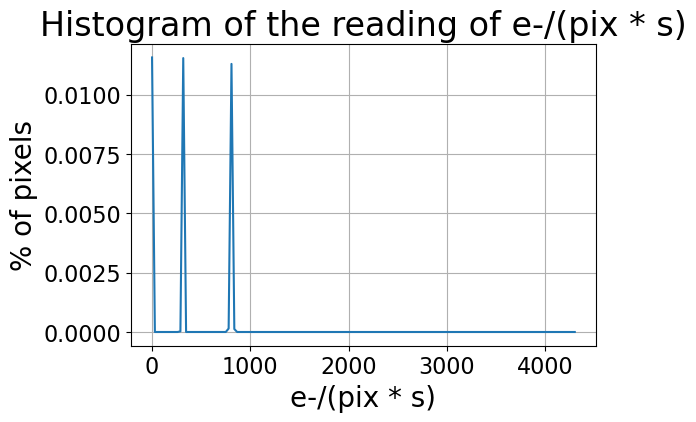

In [10]:
histo, binEdge = np.histogram(ADUPerExposure,bins=150,density=True)

plt.figure(figsize=(6,4))
plt.plot(binEdge[:-1],histo)
plt.title('Histogram of the reading of e-/(pix * s)')
plt.xlabel('e-/(pix * s)')
plt.ylabel('% of pixels')
plt.show()

### Discussion

As shown in the top histogram, the dark current in these images peak in 3 different areas. Upon further investigation, the reading of the dark current was different with different exposure times. I wasn't sure exactly why this is, as this shouldn't be the case. The dark current should be independent of exposure time (since you divide it out). Also shown in the histogram though is the cosmic ray readings. As expected, there is a long tail on the top end, indicating that some pixels were significantly brighter than most. When combining the images, I need to ensure that there is outlier regection.

---

## Part 9

Use CCDPROC.COMBINE to combine darks together to make a master dark. You will need
to play with different combination parameters to see which one does the best job of
eliminating cosmic rays. At a minimum, do

- A straight average of all dark frames.
- A straight median of all dark frames.
- An average where outlier pixels are rejected if they are more than 3σ away from the mean.
- A median where outlier pixels are rejected if they are more than 3σ away from the mean.

Use the resulting RMS in the master image as an indicator of which combination procedure
is best. Compare your master dark to your master bias to estimate the significance of the
highest dark count pixels. How many times larger is the typical dark current than the
noise (σ) in the master image?

---

In [11]:
#Straight average
averageDark = ccdp.combine(dark_files,unit='adu',method='average',sigma_clip=False,mem_limit=350e6)

#Straight median
medianDark = ccdp.combine(dark_files,unit='adu',method='median',sigma_clip=False,mem_limit=350e6)

#Average with 3 sigma clip (Default is 3 sigma)
averageClipDark = ccdp.combine(dark_files,unit='adu',method='average',sigma_clip=True,mem_limit=350e6)

#Median with 3 sigma clip (Default is 3 sigma)
medianClipDark = ccdp.combine(dark_files,unit='adu',method='median',sigma_clip=True,mem_limit=350e6)

INFO:astropy:splitting each image into 9 chunks to limit memory usage to 350000000.0 bytes.


INFO: splitting each image into 9 chunks to limit memory usage to 350000000.0 bytes. [ccdproc.combiner]


INFO:astropy:splitting each image into 13 chunks to limit memory usage to 350000000.0 bytes.


INFO: splitting each image into 13 chunks to limit memory usage to 350000000.0 bytes. [ccdproc.combiner]


INFO:astropy:splitting each image into 9 chunks to limit memory usage to 350000000.0 bytes.


INFO: splitting each image into 9 chunks to limit memory usage to 350000000.0 bytes. [ccdproc.combiner]


INFO:astropy:splitting each image into 13 chunks to limit memory usage to 350000000.0 bytes.


INFO: splitting each image into 13 chunks to limit memory usage to 350000000.0 bytes. [ccdproc.combiner]


In [12]:
print('Average Dark, No clip: RMS={}'.format(np.std(averageDark.data)))
print('Median Dark, No clip: RMS={}'.format(np.std(medianDark.data)))
print('Average Clipped Dark, No clip: RMS={}'.format(np.std(averageClipDark.data)))
print('Median Clipped Dark, No clip: RMS={}'.format(np.std(medianClipDark.data)))

#Lowest RMS is in Average with sigma clipping

Average Dark, No clip: RMS=3.076591342639415
Median Dark, No clip: RMS=2.918116967637125
Average Clipped Dark, No clip: RMS=2.8313169722072056
Median Clipped Dark, No clip: RMS=2.9180825137797073


In [13]:
avgMasterBias = np.average(masterBias.data)
print('Average Master bias={}'.format(avgMasterBias))

avgMasterDark = np.average(averageClipDark)
print('Average Dark Current={}'.format(avgMasterDark))

Average Master bias=665.6926224612566
Average Dark Current=658.6855578401905


In [14]:
print('Typical dark current={}'.format(avgMasterDark))

print('Noise in master image={}'.format(np.std(averageClipDark)))

print('Which means typical dark current is {0:4.2f}x bigger than the noise'
      .format(avgMasterDark/np.std(averageClipDark)))

Typical dark current=658.6855578401905
Noise in master image=2.8313169722072056
Which means typical dark current is 232.64x bigger than the noise


### Discussion

Based on these different combinations, the combined dark using average and 3$\sigma$ clipping showed the lowest RMS, suggesting that this method is the best. Also, the error in the bias and the error in dark current are similar in scale. I'm not entirely sure what this means though. Finally, the average value in the master dark is >200x greater than the error.